# Assignment 2: Quantization and Speech Coding
#### EQ2321 Speech and Audio Signal Processing

Max. grade: 50

# Introduction

Throughout this assignment we will use the speech data in `data["speech8"]` which is sampled at 8 kHz. `speech8` will be used both for tuning (training, optimizing) and evaluating the speech coders (evaluating on the training data is called closed test evaluation). Normally this is considered inappropriate (why?), but
we accept it here for simplicity.
You will frequently be asked to evaluate the SNR which is calculated like
$SNR = 10 \log 10 \frac{\sigma_x^2}{\sigma_q^2}$, where $X(n)$ is input speech to the coder, and $q(n) =
X(n) − \hat{X}(n)$ is the quantization error, where $\hat{X}(n)$ is the quantized speech.
Thus, calculating the SNR amounts to estimating $\sigma_x^2$, and $\sigma_q^2$.
Please note that the last part of the assignment may be the most time
consuming. There you are asked to design a forward energy and filter adaptive
DPCM coder and you are not given many instructions. Make sure you allocate
enough time for this last part!

## The Uniform Scalar Quantizer (4 pts)

In this task we implement the simplest quantizer of all: the uniform scalar
quantizer (USQ). USQs will be used frequently in this assignment.
Encoding and transmission by USQ is sometimes called Pulse Code Modulation (PCM).

In [3]:
import pickle as pkl

def read_assignment_file(fname):
    with open(fname,"rb") as f:
        d=pkl.load(f)
    return d

assignment_file = "assignment2.pkl"
data=read_assignment_file(assignment_file)

# the speech data is data["speech8"]

In [12]:
from scipy.io import wavfile
import numpy as np

def read_wav(fname):
    raw_data=wavfile.read(fname)
    return raw_data[1].astype(np.float32), raw_data[0]


# https://python-sounddevice.readthedocs.io/en/0.3.6/
# !pip install sounddevice

import sounddevice as sd

def play_wav(x,fs):
    sd.play(x.astype(np.int16),fs)

### Question 1（2 pts)

Implement a uniform scalar encoder:

```python
def sq_enc(xin, n_bits, xmax, m):
    """
    xin is a vector with the original speech samples,
    n_bits is the number of bits available to quantize one sample in the quantizer (i.e., the rate),
    xmax and m define the range of the quantizer from m-xmax to m+xmax,
       so that the width of each quantization interval is ∆ = 2 × xmax/L,
           where L is the number of quantization intervals and corresponding reconstruction values.
       m defines the mean (or offset) of the quantizer reconstruction levels.

    The function should return the index of the chosen quantization level.
    """
    return idx
```

Setting m = 0 defines a “midrise” quantizer, and m = $\frac{\Delta}{2}$ gives a "midtread" quantizer (see the course book sec. 7.2).


Implement also the corresponding decoder function
```python
def sq_dec(idx, n_bits, xmax, m)
    """See sq_enc for the definition of the inputs.
    outq is the vector with the quantized values for idx.
    """
    
    return outq
```
The USQ is a highly structured quantizer. The encoder can be imple-
mented essentially by only a scalar division (no multiplications, compar-
isons or loops are needed), making the computational complexity inde-
pendent of the bitrate. Make sure your encoder has a computational
complexity independent of the bitrate!


In [4]:
def sq_enc(xin, n_bits, xmax, m):
    L = 2 ** n_bits  # 量化级别的数量
    delta = 2 * xmax / L  # 每个量化间隔的宽度

    idx = ((xin - (m - xmax)) / delta).astype(int)
    idx = np.clip(idx, 0, L - 1) 
    return idx

In [5]:
def sq_dec(idx, n_bits, xmax, m):
    L = 2 ** n_bits  # 量化级别的数量
    delta = 2 * xmax / L  # 每个量化间隔的宽度

    outq = (idx + 0.5) * delta + (m - xmax)
    return outq

### Question 2 (2 pts)

Run the encoder and decoder on a ramp signal `x=np.linspace(-6,6,1201)`. Use a `2-bit` quantizer with $x_{max} = 4$. 

Plot the quantizer output as a function of the input. 

Make sure the output levels are exactly where you expect them to be.

Use a quantizer mean $m=0$. Do a similar plot with $m=1.5$.

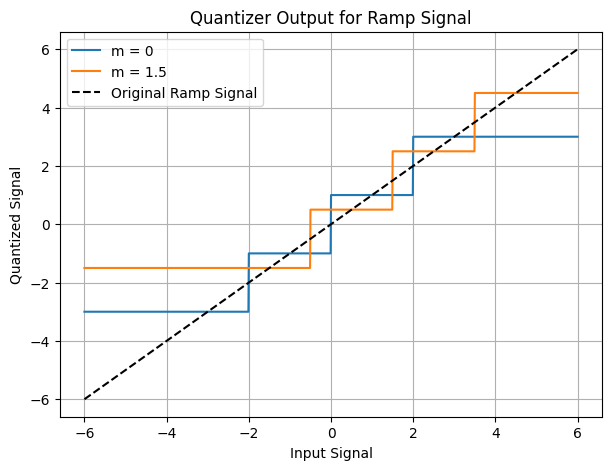

In [6]:
import numpy as np
import matplotlib.pyplot as plt


x = np.linspace(-6, 6, 1201)


n_bits = 2
xmax = 4

means = [0, 1.5]

# Plot
plt.figure(figsize=(7, 5))

for mean in means:
    # Quantize
    quantized_indices = sq_enc(x, n_bits, xmax, mean)
    
    # Decode
    reconstructed_values = [sq_dec(idx, n_bits, xmax, mean) for idx in quantized_indices]
    
    # Plot
    plt.plot(x, reconstructed_values, label=f'm = {mean}')

plt.plot(x, x, 'k--', label='Original Ramp Signal')
plt.xlabel('Input Signal')
plt.ylabel('Quantized Signal')
plt.title('Quantizer Output for Ramp Signal')
plt.legend()
plt.grid(True)
plt.show()


## Parametric Coding of Speech (23 pts)

In this task we complete our design of the vocoder from assignment 1.
Note that the speech used in this assignment is different from assignment 1 and if
your vocoder analysis is not robust you may have to retune the analysis for this
assignment.
You are encouraged to use your vocoder from assignment 1. This means reuse the functions "analysis"..., "synthesis"...

In practice, a speech coder must operate on a frame-by-frame basis, and transmit compressed data as quickly as possible in order to keep the delay short.
However, you may have implemented your vocoder in an off-line fashion (the pitch estimator is easier to implement like that for example). 


In [7]:
from scipy import signal
from scipy.linalg import solve_toeplitz, toeplitz
def xcorr_M(x,y,M=25):
#     """
#     Perform Cross-Correlation on x and y
#     x    : 1st signal
#     y    : 2nd signal

#     returns
#     lags : lags of correlation
#     corr : coefficients of correlation
#     """
    corr = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(len(x), len(y), mode="full")
    idx=(lags>=-M) & (lags<=M)
    corr = corr[idx]
    lags=lags[idx]
    return lags[len(lags)//2:], corr[len(lags)//2:]


def analysis(x, alen, ulen, M):
    N = len(x)
    naf = (N-alen+ulen)//ulen
    n1 = 0
    n_zerocrossing = 0
    threshold = 0.3
    M = 10 # M is the prediction order of the LP analysis
    
    # Initialization
    E = np.zeros((naf, 1)) # normalized frame energy
    ZC = np.zeros((naf, 1)) # The normalized number of zero crossings
    V = np.zeros((naf, 1)) # Equal to 1 if voiced, 0 if unvoiced.(detection result)
    A = np.zeros((naf, M+1)) # vocal tract filter coefficients # M+1 allows space for the leading 1
    P = np.zeros((naf, 1)) # Pitch period in samples
    
    # Inside loop
    for n in range(0,naf):          
        xf = x[n1:n1+alen] # extract one frame
        sum_ = 0
        n_zerocrossing = 0
        
        # number of zero crossings for voiced/unvoiced detection
        for n2 in range(len(xf)-1):
            if xf[n2] * xf[n2+1] < 0: 
                n_zerocrossing = n_zerocrossing + 1
                
        ZC[n] = n_zerocrossing / len(xf) # The normalized number of zero crossings (zero crossing rate)
        if ZC[n] < threshold:
            V[n] = 1 # voiced frame
        else:
            V[n] = 0 # unvoiced frame
        
        # normalized frame energy
        for n2 in range(len(xf)):
            sum_ += (xf[n2]**2) / len(xf)
        E[n] = sum_  
        
        # vocal tract filter coefficients    
        xf_window = xf*signal.windows.hann(alen)
        lags, r = xcorr_M(xf_window, xf_window,M=M)
        a = np.concatenate([np.ones(1), solve_toeplitz(r[:-1], -r[1:])]).reshape(-1,1) # Make sure the polynomial coefficients are in a row vector
        A[n,:] = a.T
        
        # pitch period
        corr = signal.correlate(xf, xf, mode="full")
        corr_positive = int(len(corr)/2)
        corr_half = corr[corr_positive:] # right half area of the acf
        acf_peaks, _ = signal.find_peaks(corr_half) # return index of the peaks
        index = np.argmax(corr_half[acf_peaks])
        P[n] = acf_peaks[index] # Pitch period in samples

        n1 = n1 + ulen   

    return E, ZC, V, A, P

In [8]:
def synthesis(E, ZC, V, A, P, ulen):
    n_frames = A.shape[0] # Assuming filter coefficients are stored row-wise
    
    # Create a pulse train excitation:
    cp = 80 # Constant pitch period in samples
    pexc = np.zeros((n_frames*ulen))
    pexc[0::cp] = 1
    E2 = np.zeros((n_frames, 1))
    P = P.reshape(-1)
    
    # Create noise excitation:
    nexc = np.random.randn(n_frames * ulen)
    n1 = 0
    Z = np.array([])
    s = np.zeros((n_frames*ulen))
    count = 0
    
    for n in range(0, n_frames):   
        # Filter the excitation through the production (vocal tract) filter:      
        # Low pass filter
        if Z.shape[0] == 0: # 1st iteration
            if V[n] == 1:
                while count < P[n]:
                    count = count + 1
                cp=P[n];
                pexc=np.zeros((n_frames*ulen))
                pexc[0::int(cp)] = 1
                
                s[n1:n1+ulen] = signal.lfilter(np.array([1]), A[n,:], pexc[n1:n1+ulen])
                Z = signal.lfiltic(np.array([1]), A[n,:], s[n1:n1+ulen], x=pexc[n1:n1+ulen])
            else:
                s[n1:n1+ulen] = signal.lfilter(np.array([1]), A[n,:], nexc[n1:n1+ulen])
                Z = signal.lfiltic(np.array([1]), A[n,:], s[n1:n1+ulen], x=nexc[n1:n1+ulen])
        else:
            if V[n] == 1:
                while count < P[n]:
                    count = count + 1
                cp=P[n];
                pexc=np.zeros((n_frames*ulen))
                pexc[0::int(cp)]=1
                
                s[n1:n1+ulen],Z = signal.lfilter(np.array([1]), A[n,:], pexc[n1:n1+ulen], zi=Z)
            else:
                s[n1:n1+ulen],Z = signal.lfilter(np.array([1]), A[n,:], nexc[n1:n1+ulen], zi=Z)

        sum_ = 0
        for n2 in range(0, n_frames):
            sum_ += (s[n2]**2) / ulen
        E2[n] = sum_
        s[n1:n1+ulen] = s[n1:n1+ulen] * np.sqrt(E[n]/E2[n])
        n1 = n1+ulen
    
    # Rescale the output signal to the range of 16-bit integer
    s_scaled = s * (32767 / np.max(np.abs(s)))
    s_scaled = s_scaled.astype(np.int16)
    return s_scaled


### Quantizing the Frame Energy (8 pts)

#### Question 1 (1 pts)

Provide a plot of the histogram of the energy parameter.
Indicate in the plot the range of the quantizer, i.e., mark the outer boundaries $m\pm xmax$ (also mark m).
Note that the pdf has a non-zero mean.

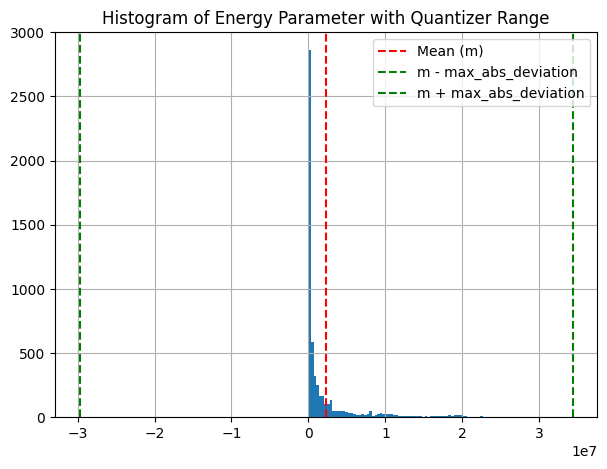

In [7]:
import numpy as np
import matplotlib.pyplot as plt

x = data["speech8"].reshape(-1)
x = np.float64(x)
alen=256
ulen=8
M=10
N = len(x)
naf = (N-alen+ulen)//ulen

E, ZC, V, A, P = analysis(x, alen, ulen, M)

# E = np.log2(E)

# E = np.sqrt(E)

# Calculate mean and maximum deviation from mean
mean_E = np.mean(E)
max_deviation = np.max(np.abs(E - mean_E))

# Define quantizer range
m = mean_E
max_abs_deviation = max_deviation

plt.figure(figsize=(7, 5))
plt.hist(E, bins=100)
plt.axvline(x=m, color='r', linestyle='--', label='Mean (m)')
plt.axvline(x=m-max_abs_deviation, color='g', linestyle='--', label='m - max_abs_deviation')
plt.axvline(x=m+max_abs_deviation, color='g', linestyle='--', label='m + max_abs_deviation')
plt.title('Histogram of Energy Parameter with Quantizer Range')
plt.legend()
plt.grid(True)
plt.show()

#### Question 2 (2 pts)

Run the vocoder with a uniform scalar energy quantizer according to the design above.
Find the rate at which you cannot hear the quantization distortion.

When the rate (n_bits) is equal to 11, we do not hear the quantization distortion.

In [11]:
from scipy.io.wavfile import write

x = data["speech8"].reshape(-1)
x = np.float64(x)
alen=256
ulen=32
M=10
N = len(x)
naf = (N-alen+ulen)//ulen
n_bits=11

E, ZC, V, A, P = analysis(x, alen, ulen, M)

mean = np.mean(E)
xmax = np.max(np.abs(E - mean))

quantized_indices = sq_enc(E, n_bits, xmax, mean)
reconstructed_energy = [sq_dec(idx, n_bits, xmax, mean) for idx in quantized_indices]

output = synthesis(reconstructed_energy, ZC, V, A, P, ulen)

# Rescale the output signal to the range of 16-bit integer
output_scaled = output * (32767 / np.max(np.abs(output)))
output_scaled = output_scaled.astype(np.int16)

# Write the scaled output signal to a WAV file
output_file = "output.wav"
write(output_file, 8000, output_scaled)

# Output the filename for reference
print("Vocoder output saved as:", output_file)

output="output.wav"
output_signal, fs = read_wav(output)
play_wav(output_signal,8000)

Vocoder output saved as: output.wav


In [7]:
from scipy.io.wavfile import write

x = data["speech8"].reshape(-1)
x = np.float64(x)
alen=256
ulen=32
M=10
N = len(x)
naf = (N-alen+ulen)//ulen
n_bits=11

E, ZC, V, A, P = analysis(x, alen, ulen, M)


output = synthesis(E, ZC, V, A, P, ulen)

# Rescale the output signal to the range of 16-bit integer
output_scaled = output * (32767 / np.max(np.abs(output)))
output_scaled = output_scaled.astype(np.int16)

# Write the scaled output signal to a WAV file
output_file = "output.wav"
write(output_file, 8000, output_scaled)

# Output the filename for reference
print("Vocoder output saved as:", output_file)

output="output.wav"
output_signal, fs = read_wav(output)
play_wav(output_signal,8000)

Vocoder output saved as: output.wav


#### Question 3 (1 pts)

Take the logarithm of the energy parameter prior to quantization (does not matter which base).
Provide a plot of the histogram of the energy parameter in the log-domain.
Indicate the range of this quantizer as above.

The range of this quantizer: 3.9 ～ 30.3


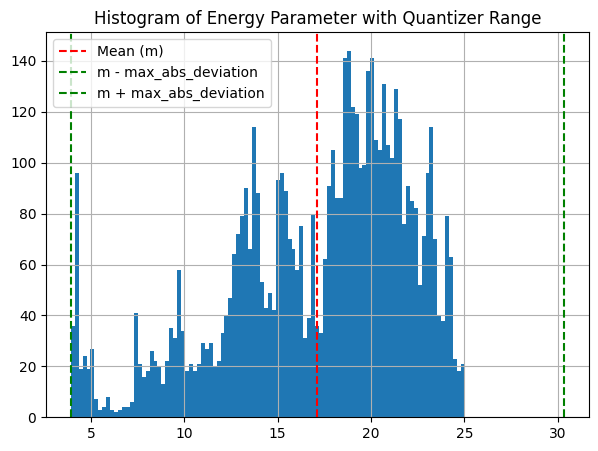

In [23]:
import numpy as np
import matplotlib.pyplot as plt

x = data["speech8"].reshape(-1)
x = np.float64(x)
alen=256
ulen=8
M=10
N = len(x)
naf = (N-alen+ulen)//ulen

E, ZC, V, A, P = analysis(x, alen, ulen, M)

E = np.log2(E)

# E = np.sqrt(E)

# Calculate mean and maximum deviation from mean
mean_E = np.mean(E)
max_deviation = np.max(np.abs(E - mean_E))

# Define quantizer range
m = mean_E
max_abs_deviation = max_deviation

print("The range of this quantizer: {:.1f} ～ {:.1f}".format(m - max_abs_deviation, m + max_abs_deviation))


plt.figure(figsize=(7, 5))
plt.hist(E, bins=100)
plt.axvline(x=m, color='r', linestyle='--', label='Mean (m)')
plt.axvline(x=m-max_abs_deviation, color='g', linestyle='--', label='m - max_abs_deviation')
plt.axvline(x=m+max_abs_deviation, color='g', linestyle='--', label='m + max_abs_deviation')
plt.title('Histogram of Energy Parameter with Quantizer Range')
plt.legend()
plt.grid(True)
plt.show()

#### Question 4 (2 pts)

Run the vocoder with a uniform scalar log-energy quantizer according to the design above.
Find the rate at which you cannot hear the quantization distortion.
Make sure to modify the decoder accordingly (apply the exp function to the quantized log-energy).

When the rate (n_bits) is equal to 6, we do not hear the quantization distortion.

In [24]:
from scipy.io.wavfile import write

x = data["speech8"].reshape(-1)
x = np.float64(x)
alen=256
ulen=32
M=10
N = len(x)
naf = (N-alen+ulen)//ulen
n_bits=6

E, ZC, V, A, P = analysis(x, alen, ulen, M)

E = np.log2(E)

mean = np.mean(E)
xmax = np.max(np.abs(E - mean))

quantized_indices = sq_enc(E, n_bits, xmax, mean)
reconstructed_energy = [sq_dec(idx, n_bits, xmax, mean) for idx in quantized_indices]

reconstructed_energy = 2 ** np.array(reconstructed_energy)

output2 = synthesis(reconstructed_energy, ZC, V, A, P, ulen)

# Rescale the output signal to the range of 16-bit integer
output2_scaled = output2 * (32767 / np.max(np.abs(output2)))
output2_scaled = output2_scaled.astype(np.int16)

# Write the scaled output signal to a WAV file
output2_file = "output2.wav"
write(output2_file, 8000, output2_scaled)

# Output the filename for reference
print("Vocoder output saved as:", output2_file)

output2="output2.wav"
output2_signal, fs = read_wav(output2)
play_wav(output2_signal,8000)

Vocoder output saved as: output2.wav


#### Question 5 (2 pts)

Which is better: energy quantization in linear or log domain?

In the log domain, we only need n_bits=6. But in the linear domain, we need n_bits=11 to avoid the quantization distortion.\
So, Energy quantization in log domain is better. 

### Quantizing the Pitch and Voiced/Unvoiced Decision (2 pts)

#### Question 1 (2 pts)

Come up with an efficient way to encode the pitch and voiced/unvoiced decision.

We only need 1 bit to encode the voiced/unvoiced decision.

For pitch, we also quantized it in log domain, based on the previous codes.

In [12]:
from scipy.io.wavfile import write

x = data["speech8"].reshape(-1)
x = np.float64(x)
alen=256
ulen=32
M=10
N = len(x)
naf = (N-alen+ulen)//ulen
n_bits=8

E, ZC, V, A, P = analysis(x, alen, ulen, M)

P = np.log2(P)

mean = np.mean(P)
xmax = np.max(np.abs(P - mean))

quantized_indices = sq_enc(P, n_bits, xmax, mean)
reconstructed_energy = [sq_dec(idx, n_bits, xmax, mean) for idx in quantized_indices]

reconstructed_energy = 2 ** np.array(reconstructed_energy)

output3 = synthesis(E, ZC, V, A, reconstructed_energy, ulen)

# Rescale the output signal to the range of 16-bit integer
output3_scaled = output3 * (32767 / np.max(np.abs(output3)))
output3_scaled = output3_scaled.astype(np.int16)

# Write the scaled output signal to a WAV file
output3_file = "output3.wav"
write(output3_file, 8000, output3_scaled)

# Output the filename for reference
print("Vocoder output saved as:", output3_file)

output3="output3.wav"
output3_signal, fs = read_wav(output3)
play_wav(output3_signal,8000)

Vocoder output saved as: output3.wav


### Quantizing the LP parameters (4 pts)

#### Question 1 (4 pts)

For the quantization of LP parameters, we will use a vector quantizer (VQ).
You do not need to optimize (train) the VQs; that has been done for you, and
the codebooks can be found in the given data 'lsfCB1' and 'lsfCB2' in
the file assignment2.pkl
The codebooks constitute a multistage VQ. 
`lsfCB1` is a 10 bit VQ optimized on 10 dimensional LSF vectors. 
`lsfCB2` is a 10 bit second stage residual codebook.
You extract these codebooks by calling data['lsfCB1'], data['lsfCB2']

What you need to do is to program an encoding function and a corresponding decoding function for a multistage VQ. 
A suitable calling syntax for these functions can be

```python
def encodefilter(A, cb1, cb2):
    return codeA
```

```python
def decodefilter(codeA, cb1, cb2):
    return Aq
```

Here A is a matrix with filter coefficients stored row-wise, and codeA is a two-column matrix with the corresponding code indices, stored row-wise.

Notes:

1. To convert between polynomial (a-) coefficients and LSFs see `poly2lsf` and `lsf2poly`. You migh require toolboxes such as https://pyspectrum.readthedocs.io/en/latest/install.html

2. `poly2lsf` requires the polynomial coefficients to correspond to a minimum phase whitening filter. 
This is guaranteed by the autocorrelation LP analysis.
`lsf2poly` requires that the LSFs correspond to a minimum phase whitening filter.
The multistage VQ can output LSFs that do not satisfy this.
As a precaution simply sort the LSFs prior to calling `lsf2poly`.
Also check so they are between 0 and $\pi$.

In [10]:
import numpy as np
from spectrum import poly2lsf, lsf2poly
cb1, cb2 = data['lsfCB1'], data['lsfCB2'] # matrix: n*10

def encodefilter(A, cb1, cb2):
    codeA = []
    for i in range(A.shape[0]):
        # Convert filter coefficients to LSFs
        lsf = poly2lsf(A[i, :])
        # Quantize using the first codebook
        indices1 = np.argmin(np.sum((lsf - cb1)**2, axis=1))
        quantized_lsf1 = cb1[indices1,:]
        # Calculate the residual between original and quantized LSFs
        residual_lsf = lsf - quantized_lsf1
        # Quantize residual using the second codebook
        indices2 = np.argmin(np.sum((residual_lsf - cb2)**2, axis=1))
        codeA.append([indices1, indices2]) # Combine indices for both stages    
    return np.array(codeA)

def decodefilter(codeA, cb1, cb2):
    Aq = []
    for i in range(codeA.shape[0]):
        # Reconstruct LSFs
        reconstructed_lsf = cb1[codeA[i, 0],:] + cb2[codeA[i, 1],:]    
        # Convert LSFs to filter coefficients
        Aq.append(lsf2poly(reconstructed_lsf))    
    return np.array(Aq)

# codeA = encodefilter(A, cb1, cb2)
# Aq = decodefilter(codeA, cb1, cb2)

### Optimizing the Bit Allocation (9 pts)

Here you experiment a little with the number of bits to use for each parameter.
Since you are provided with the LSF codebooks, you cannot experiment with the number of bits spent on LP parameter quantization.
LP quantization contributes a lot to the total number of bits, and the choice of LSF codebook size
vs. performance is crucial in vocoder design, but here we keep the LSF codebook
size fixed.
Find a bit allocation (i.e. the number of bits to use in each quantizer) for the energy, pitch, voiced/unvoiced quantizers, such that the quality is the same as when these parameters are unquantized (the effect of the LP parameter quantization is always present).

#### Question 1 (2 pts)

Evaluate the SNR for your design above.

In [16]:
# Quantize E
E, ZC, V, A, P = analysis(x, alen, ulen, M)
n_bits_E = 6
E = np.log(E)
mean = np.mean(E)
# xmax = np.max(np.abs(E - mean))
xmax = np.max(E) - mean

quantized_indices = sq_enc(E, n_bits_E, xmax, mean)
outq_E = [sq_dec(idx, n_bits_E, xmax, mean) for idx in quantized_indices]
outq_E = np.exp(outq_E)

recon_speech_logE = synthesis(outq_E, ZC, V, A, P, ulen)
play_wav(recon_speech_logE,8000)

In [24]:
# Quantize P
n_bits_P=6
P_log = np.log(P)

# log domain
mean_P_log = np.mean(P_log)
xmax_P_log = np.max(P_log) - mean_P_log

idx_P_log = sq_enc(P_log, n_bits_P, xmax_P_log, mean_P_log)
outq_P_log = [sq_dec(idx, n_bits_P, xmax_P_log, mean_P_log) for idx in idx_P_log]
P_decoded_log = np.exp(outq_P_log)
recon_speech_logP = synthesis(E, ZC, V, A, P_decoded_log, ulen)

play_wav(recon_speech_logP, fs)

In [25]:
speech_data = data["speech8"]
x = data["speech8"].reshape(-1)
x = np.float64(x)
fs = 8000
alen=256
ulen=32
M=10
N = len(x)
naf = (N-alen+ulen)//ulen
n_bits_E=6
n_bits_P=6
E, ZC, V, A, P = analysis(x, alen, ulen, M)
E_log = np.log(E)  # log domain
P_log = np.log(P)

mean_E_log = np.mean(E_log)
xmax_E_log = np.max(E_log) - mean_E_log
idx_E_log = sq_enc(E_log, n_bits_E, xmax_E_log, mean_E_log)
outq_E_log = [sq_dec(idx, n_bits_E, xmax_E_log, mean_E_log) for idx in idx_E_log]
outq_E_log = np.exp(outq_E_log)

mean_P_log = np.mean(P_log)
xmax_P_log = np.max(P_log) - mean_P_log
idx_P_log = sq_enc(P_log, n_bits_P, xmax_P_log, mean_P_log)
outq_P_log = [sq_dec(idx, n_bits_P, xmax_P_log, mean_P_log) for idx in idx_P_log]
outq_P_log = np.exp(outq_P_log)

codeA = encodefilter(A, cb1, cb2)
Aq = decodefilter(codeA, cb1, cb2)

recon_speech = synthesis(outq_E_log, ZC, V, Aq, outq_P_log, ulen)

# SNR = 10*np.log10(np.var(speech_data[:len(recon_speech),0])/np.var(speech_data[:len(recon_speech),0]-recon_speech))
SNR = 10*np.log10(np.var(x[:len(recon_speech)])/np.var(x[:len(recon_speech)]-recon_speech))
print('SNR =', SNR)

SNR = -5.89984897884957


#### Question 2 (3 pts)

What number of bits do you suggest for the pitch? For the energy? For the
voiced/unvoiced decision?

Pitch: 6 bits; Energy: 6 bits; Voiced/unvoiced decision: 1 bits

#### Question 3 (2 pts)

What is the rate in bits per sample of your vocoder with the bit allocation
suggested above? In bits per second?

Whole speech: 358 frames, frame length: alen=256.  
Each frame requires 20bits for LP coefficients, 6bits for Gain and 6bits for Pitch, and 1bits for Voiced/Unvoiced.  

For each frame, we need 33bits in total, and 33/256=0.129 bits per sample. 
In bits per second, it is 8000*0.129=1032bits.

#### Question 4 (2 pts)

Does it make sense to evaluate SNR here? Why or why not?

It's not very make sense to evaluate SNR here. As the SNR is -5.9dB which means the noise is large compare to the signal.   
In this low SNR case, the SNR value cannot present the reconstruction speech quality very well.

## Speech Waveform Quantization (10 pts)

#### Uniform Scalar Quantization of Speech

We will in the following design our quantizers using $x_{max} = \sigma_Xk$ , where $\sigma_X$
is the variance of speech and k is an experimentally tuned parameter (here it is tuned to maximize SNR). 

`k` is rate dependent and the SNR optimal `k` for rates 1 to 16 are
```python
l=[0.95, 2.1, ?, 4.95, 6.3, 7.65, 8.85, 9.95, 10.6, 11.0, 11.1, 11.2, 11.15, 11.2,
11.15, 11.15]
```

The optimal (in terms of SNR) value for $R = 3$ is to be found experimentally.
Run the quantizer with different values of k, and measure the SNR, to find the optimal choice.

##### Question 1 (2 pts)

Evaluate the optimal `k` for $R = 3$.

The k corresponding to the largest SNR: 3.4


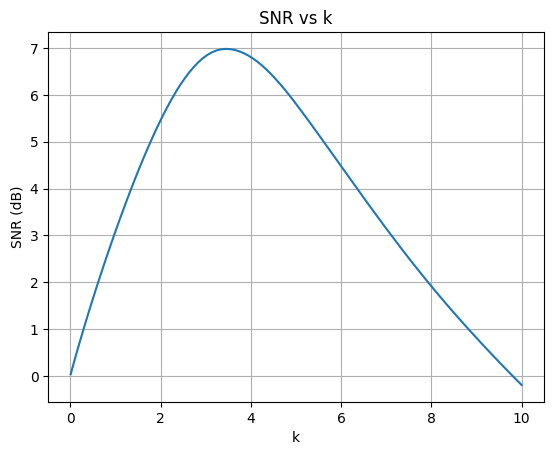

In [27]:
from scipy.io.wavfile import write
import numpy as np
import matplotlib.pyplot as plt

x = data["speech8"].reshape(-1)
x = np.float64(x)
max_SNR = float('-inf')  # 初始化最大 SNR 为负无穷大
optimal_k = None

n_bits = 3

# 生成一组不同的 k 值
k_values = np.linspace(0.01, 10, 100)  # 可以根据需要更改起始值和步长

# 存储每个 k 值下的 SNR
SNR_values = []

for k in k_values:
    mean = 0
    xmax = np.std(x) * k

    quantized_indices = sq_enc(x, n_bits, xmax, mean)
    reconstructed_x = [sq_dec(idx, n_bits, xmax, mean) for idx in quantized_indices]

    signal_power = np.mean(x ** 2)
    noise = x - reconstructed_x
    noise_power = np.mean(noise ** 2)

    SNR = 10 * np.log10(signal_power / noise_power)
    SNR_values.append(SNR)
    
    if SNR > max_SNR:
        max_SNR = SNR
        optimal_k = k

# 打印最大 SNR 对应的 k 值
print("The k corresponding to the largest SNR: {:.1f}".format(optimal_k))

# 绘制 SNR 关于 k 的图像
plt.plot(k_values, SNR_values)
plt.xlabel('k')
plt.ylabel('SNR (dB)')
plt.title('SNR vs k')
plt.grid(True)
plt.show()

##### Question 2 (2 pts)

Run the quantizer at rates [16, 15, 14, . . ., 2, 1], and evaluate the SNR
for each rate.
Provide a plot of the SNR as a function of rate.

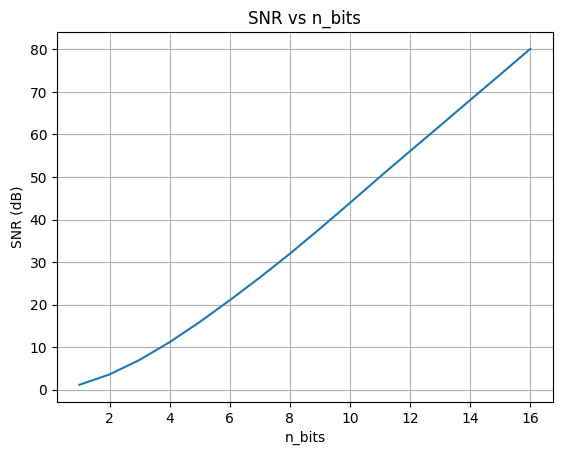

In [28]:
from scipy.io.wavfile import write
import numpy as np
import matplotlib.pyplot as plt

def sq_enc(xin, n_bits, xmax, m):
    L = 2 ** n_bits  # 量化级别的数量
    delta = 2 * xmax / L  # 每个量化间隔的宽度

    idx = ((xin - (m - xmax)) / delta).astype(int)
    idx = np.clip(idx, 0, L - 1) 
    return idx

def sq_dec(idx, n_bits, xmax, m):
    L = 2 ** n_bits  # 量化级别的数量
    delta = 2 * xmax / L  # 每个量化间隔的宽度

    outq = (idx + 0.5) * delta + (m - xmax)
    return outq


x = data["speech8"].reshape(-1)
x = np.float64(x)

k = [0.95, 2.1, 3.4, 4.95, 6.3, 7.65, 8.85, 9.95, 10.6, 11.0, 11.1, 11.2, 11.15, 11.2, 11.15, 11.15]

# 存储每个 k 值下的 SNR
SNR_values = []

for n_bits in range(1, len(k) + 1):  # 使用 k 的索引作为 n_bits
    mean = 0
    xmax = np.std(x) * k[n_bits - 1]  # 根据 n_bits 取对应的 k 值

    quantized_indices = sq_enc(x, n_bits, xmax, mean)
    reconstructed_x = [sq_dec(idx, n_bits, xmax, mean) for idx in quantized_indices]

    signal_power = np.mean(x ** 2)
    noise = x - reconstructed_x
    noise_power = np.mean(noise ** 2)

    SNR = 10 * np.log10(signal_power / noise_power)
    SNR_values.append(SNR)

# 绘制 SNR 关于比特率的图像
plt.plot(range(1, len(k) + 1), SNR_values)
plt.xlabel('n_bits')
plt.ylabel('SNR (dB)')
plt.title('SNR vs n_bits')
plt.grid(True)
plt.show()


##### Question 3 (2 pts)

Provide a graph of the theoretical SNR in the same plot as the experimental SNR plot.
For the theoretical SNR, assume that the number of quantization levels is high, and that overload is negligible.

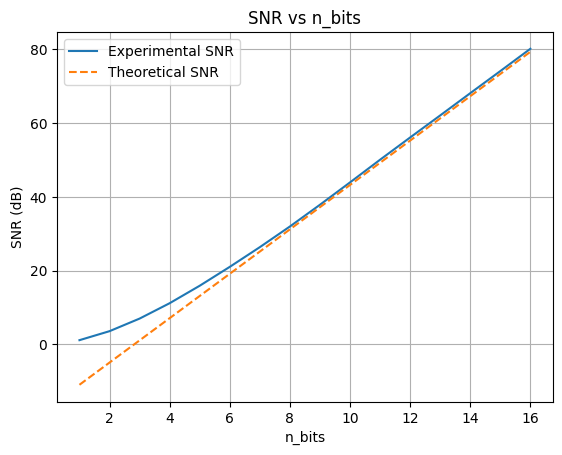

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def sq_enc(xin, n_bits, xmax, m):
    L = 2 ** n_bits  # Number of quantization levels
    delta = 2 * xmax / L  # Quantization step size

    idx = ((xin - (m - xmax)) / delta).astype(int)
    idx = np.clip(idx, 0, L - 1) 
    return idx

def sq_dec(idx, n_bits, xmax, m):
    L = 2 ** n_bits  # Number of quantization levels
    delta = 2 * xmax / L  # Quantization step size

    outq = (idx + 0.5) * delta + (m - xmax)
    return outq

x = data["speech8"].reshape(-1)
x = np.float64(x)

k = [0.95, 2.1, 3.4, 4.95, 6.3, 7.65, 8.85, 9.95, 10.6, 11.0, 11.1, 11.2, 11.15, 11.2, 11.15, 11.15]

SNR_values = []
theoretical_SNR_values = []  # To store theoretical SNR values

for n_bits in range(1, len(k) + 1):  
    mean = 0
    xmax = np.std(x) * k[n_bits - 1]  

    quantized_indices = sq_enc(x, n_bits, xmax, mean)
    reconstructed_x = [sq_dec(idx, n_bits, xmax, mean) for idx in quantized_indices]

    signal_power = np.mean(x ** 2)
    noise = x - reconstructed_x
    noise_power = np.mean(noise ** 2)

    SNR = 10 * np.log10(signal_power / noise_power)
    SNR_values.append(SNR)

#     # Calculate theoretical SNR
#     L = 2 ** n_bits
#     delta = 2 * xmax / L
#     Nq = delta**2 / 12
#     theoretical_SNR = 10 * np.log10(signal_power / Nq)
    theoretical_SNR=6.02*n_bits+10*np.log10(3*1/150)
    theoretical_SNR_values.append(theoretical_SNR)

plt.plot(range(1, len(k) + 1), SNR_values, label='Experimental SNR')
plt.plot(range(1, len(k) + 1), theoretical_SNR_values, label='Theoretical SNR', linestyle='--')
plt.xlabel('n_bits')
plt.ylabel('SNR (dB)')
plt.title('SNR vs n_bits')
plt.legend()
plt.grid(True)
plt.show()

##### Question 4 (1 pts)

At what rate can you not tell the difference between the original and the quantized signal?

When rate = 8, we cannot tell the difference between the original and the quantized signal.

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import time

def play_wav_with_delay(x, fs):
    sd.play(x.astype(np.int16), fs)
    sd.wait()  
    

x = data["speech8"].reshape(-1)
x = np.float64(x)

# k = 7.65
# n_bits=6

# k = 8.85
# n_bits=7

k = 9.95
n_bits=8

# k = 10.6
# n_bits=9

mean = 0
xmax = np.std(x) * k

quantized_indices = sq_enc(x, n_bits, xmax, mean)
reconstructed_x = [sq_dec(idx, n_bits, xmax, mean) for idx in quantized_indices]
reconstructed_x = np.array(reconstructed_x)

noise = x - reconstructed_x

play_wav_with_delay(reconstructed_x,8000)
play_wav_with_delay(x,8000)

##### Question 5 (1 pts)

Listen to the quantization error signal, $q(n)$. 
How would you characterize $q(n)$ for a system operating at rate $R = 1$.
Increase the rate (up to $R \approx 12$) and describe how the character of $q(n)$ changes.

When rate=1, we can hear that q(n) contains a lot of information about the original signal, that is to say, a lot of information is lost.\
As rate increases, we find less and less valid information in the noise.Finally, we consider that the noise can be recognized as a white noise when rate = 8.

In [41]:
import numpy as np
import matplotlib.pyplot as plt

x = data["speech8"].reshape(-1)
x = np.float64(x)

# k = 7.65
# n_bits=6

# k = 8.85
# n_bits=7

k = 9.95
n_bits=8

# k = 10.6
# n_bits=9


mean = 0
xmax = np.std(x) * k

quantized_indices = sq_enc(x, n_bits, xmax, mean)
reconstructed_x = [sq_dec(idx, n_bits, xmax, mean) for idx in quantized_indices]

noise = x - reconstructed_x

play_wav(noise,8000)


##### Question 6 (OPTIONAL 2 pts)

Is it advantageous to have a reconstruction level in the origin for low rates?
Compare (by listening) midrise and midtread quantizers at low bit rates.

We already know that the midrise quantizer has a reconstruction level in the origin. We plot two SNR-n_bits curves for the midrise quantizer and mistrend quantizer. From the figure, we find that the midtrend quantizer has a better SNR when the rate is low. That is to say, it is not good to have a reconstruction level in the origin for low rates.

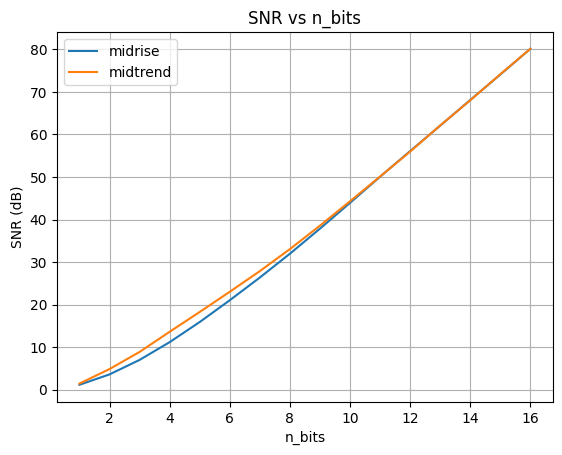

In [53]:
from scipy.io.wavfile import write
import numpy as np
import matplotlib.pyplot as plt

def sq_enc(xin, n_bits, xmax, m):
    L = 2 ** n_bits  # 量化级别的数量
    delta = 2 * xmax / L  # 每个量化间隔的宽度

    idx = ((xin - (m - xmax)) / delta).astype(int)
    idx = np.clip(idx, 0, L - 1) 
    return idx

def sq_dec(idx, n_bits, xmax, m):
    L = 2 ** n_bits  # 量化级别的数量
    delta = 2 * xmax / L  # 每个量化间隔的宽度

    outq = (idx + 0.5) * delta + (m - xmax)
    return outq


x = data["speech8"].reshape(-1)
x = np.float64(x)

k = [0.95, 2.1, 3.4, 4.95, 6.3, 7.65, 8.85, 9.95, 10.6, 11.0, 11.1, 11.2, 11.15, 11.2, 11.15, 11.15]

# 存储每个 k 值下的 SNR
SNR_values = []
SNR_values2 = []

for n_bits in range(1, len(k) + 1):  # 使用 k 的索引作为 n_bits
    mean = 0
    xmax = np.std(x) * k[n_bits - 1]  # 根据 n_bits 取对应的 k 值
    mean2=xmax/(2 ** n_bits)

    quantized_indices = sq_enc(x, n_bits, xmax, mean)
    reconstructed_x = [sq_dec(idx, n_bits, xmax, mean) for idx in quantized_indices]
    
    quantized_indices2 = sq_enc(x, n_bits, xmax, mean2)
    reconstructed_x2 = [sq_dec(idx, n_bits, xmax, mean2) for idx in quantized_indices2]

    signal_power = np.mean(x ** 2)
    noise = x - reconstructed_x
    noise_power = np.mean(noise ** 2)
    noise2 = x - reconstructed_x2
    noise_power2 = np.mean(noise2 ** 2)

    SNR = 10 * np.log10(signal_power / noise_power)
    SNR_values.append(SNR)
    SNR2 = 10 * np.log10(signal_power / noise_power2)
    SNR_values2.append(SNR2)

# 绘制 SNR 关于比特率的图像
plt.plot(range(1, len(k) + 1), SNR_values, label='midrise')
plt.plot(range(1, len(k) + 1), SNR_values2, label='midtrend')
plt.xlabel('n_bits')
plt.ylabel('SNR (dB)')
plt.title('SNR vs n_bits')
plt.legend()
plt.grid(True)
plt.show()


## Adaptive Open-Loop DPCM (13 pts)
<img src="./openloopdcm.png" alt="alt text" width="800"/>

In this section we will study open-loop Differential Pulse Code Modulation (DPCM).
Open loop DPCM can be viewed as pre-filtering, quantization, and post-filtering, see Figure 1 (the adaptation
mechanism is not shown). 
It is called open loop because the quantizer is not part of the prediction loop.

We will want to adapt both the LP coefficients and the energy in a forward fashion.
See the vocoder section for hints on how to forward adapt those.
In general the structure of open loop DPCM is similar to the vocoder structure with
one important difference: vocoders create an artificial replica of the prediction
error signal $d(n)$ (by estimating voiced/unvoiced, the pitch, energy), whereas
open loop DPCM coders quantize each sample of the prediction error signal
and thus try to preserve the original waveform. 

We recommend that you reuse as much as possible of the code from the vocoder.

#### Question 1 (4 pts)
You are not given many guidelines here. Give it your best shot and make
sure you can motivate your choice of for example
- analysis frame length,
- update length (to keep things simple make analysis and update lengths
equal, i.e., no overlapping analysis frames),
- window function (for the analysis of certain parameters),
- number of bits to quantize the energy,
- number of bits to quantize the residual,
Use the VQ as before to quantize the LP parameters (thus, you need not
decide prediction order!).

Design the PCM quantizer for the prediction error d(n) according to
$x_{max} = k \sigma_d$ . 
Optimize k for $R = 3$ (R meaning the rate of the residual quantizer), by experimenting, so that it sounds good, i.e., do not optimize SNR theoretically.

In [15]:
from scipy import signal
from scipy.linalg import solve_toeplitz, toeplitz
from scipy.fft import fft
import scipy
import pickle as pkl
import numpy as np

def read_assignment_file(fname):
    with open(fname,"rb") as f:
        d=pkl.load(f)
    return d

assignment_file = "assignment2.pkl"
data=read_assignment_file(assignment_file)

import sounddevice as sd
def play_wav(x,fs):
    sd.play(x.astype(np.int16),fs)

def xcorr(x,y,M=10):
    corr = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(len(x), len(y), mode="full")
    idx=(lags>=-M) & (lags<=M)
    corr = corr[idx]
    lags=lags[idx]
    return lags[len(lags)//2:], corr[len(lags)//2:]   # truncate，len(lags) = 21, corr(only remain last 11 values)

def DPCM_enc(x, alen, ulen, R, M, K):
    m = 0
    N = len(x)
    naf = (N-alen+ulen) // ulen  # Number of analysis frames
    n1 = 0
    A = np.zeros((naf, M+1))  # M is the prediction order.
    residual_q, xmax, x_window, residual = [], [], [], []
    for n in range(0,naf):  # on a frame basis
        xf = x[n1:n1+alen].reshape(-1)
#         xf_window = xf*signal.windows.hann(alen)
        xf_window = xf*signal.windows.hamming(alen)
#         xf_window = xf*signal.windows.boxcar(alen)
        x_window.append(xf_window)
        lags, r = xcorr(xf_window, xf_window, M=M)
        a = np.concatenate([np.ones(1), solve_toeplitz(np.array(r[:-1]), np.array(-r[1:]))]).reshape(-1,1) # Make sure the polynomial coefficients are in a row vector
        A[n,:] = a.T
        xf_hat = signal.lfilter(np.hstack(([0],-1*A[n,1:])), [1], xf_window)
#         xf_hat = signal.lfilter(A[n,:], [1], xf_window)
        res = xf_window - xf_hat
        residual.append(res)
        x_max = K*np.std(res)
        res_q = sq_enc(res, R, x_max, m)
        residual_q.append(res_q)
        xmax.append(x_max)
        n1 = n1 + ulen
    A_q = encodefilter(A, cb1, cb2)
    return np.array(residual_q), np.array(x_window), A_q, np.array(xmax), np.array(residual)

def DPCM_dec(residual, x_window, A_q, xmaxs, R):
    m = 0
    A_recon = decodefilter(A_q, cb1, cb2)
    recon_x = []
    for n in range(A_recon.shape[0]):
        d_hat = sq_dec(residual[n, :], R, xmaxs[n], m)
        recon_signal = scipy.signal.lfilter([1], A_recon[n, :], d_hat)
        recon_signal = recon_signal + d_hat
        recon_x.append(recon_signal)
    recon_x = np.array(recon_x)
    return recon_x.reshape(-1)

x = data["speech8"]
alen = 256
ulen = 256
fs = 8000
R = 3
M = 10
K = 1

residual_q, x_window, A_q, xmax, residual = DPCM_enc(x, alen, ulen, R, M, K)
speech_recon = DPCM_dec(residual_q, x_window, A_q, xmax, R)
speech_recon = speech_recon * (32767 / np.max(np.abs(speech_recon)))
speech_recon = speech_recon.astype(np.int16)

play_wav(speech_recon, fs)

#### Question 2 (1 pts)

Run your system at R = 3. 
How would you characterize the reconstructed speech? What does the quantization error sound like?


In [16]:
x = data["speech8"]
alen = 256
ulen = 256
fs = 8000
R = 3
M = 10
K = 1

residual_q, x_window, A_q, xmax, residual = DPCM_enc(x, alen, ulen, R, M, K)
speech_recon = DPCM_dec(residual_q, x_window, A_q, xmax, R)
speech = x[:len(speech_recon)].reshape(-1)
q_error = speech-speech_recon

play_wav(q_error, fs)

#### The quantization error sound similar to the raw speech.

#### Question 3 (2 pts)

What shape does the quantization error spectrum have? 
Plot a DFT based spectrum of the error for a voiced frame. 
What does theory say?

Text(0.5, 1.0, 'LP Envelop of the Spectrum for a voiced frame')

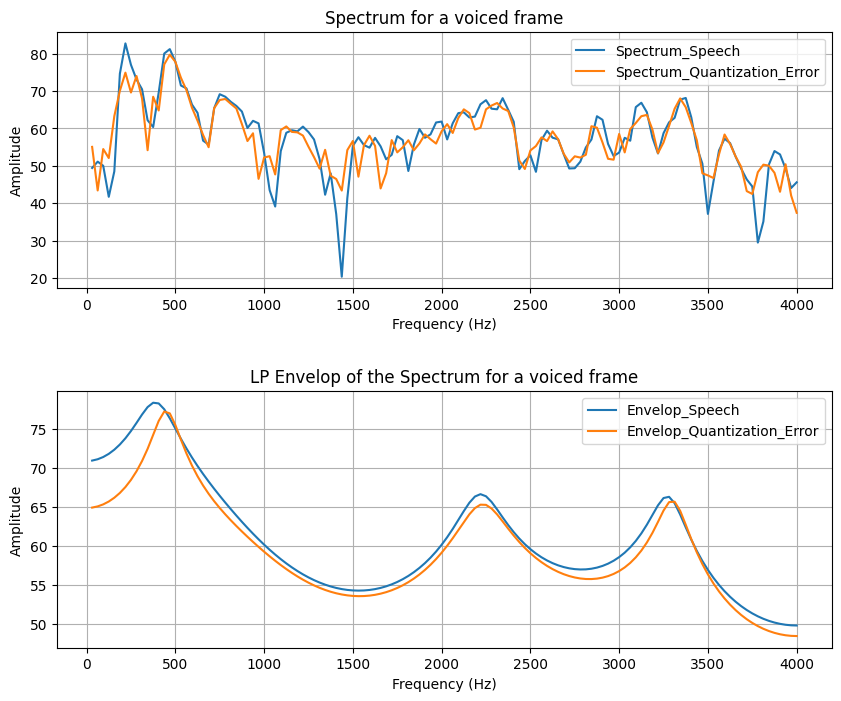

In [17]:
from scipy import signal
from scipy.fft import fft, fftshift, fftfreq
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np

def get_envelop(xf, M, N=256, fs=8000):
    xf = xf*signal.windows.hamming(N)
    lags, r = xcorr(xf, xf,M=M)
    a=np.concatenate([np.ones(1), solve_toeplitz(r[:-1], -r[1:])]).reshape(-1,1)
    e=(a.T @ r)[0]
    w, h2=signal.freqz(1,a,N,whole=True,fs=fs)    
    X = fft(xf)
    return w[1:N//2+1], np.abs(X[1:N//2+1])**2, e*np.abs(h2[1:N//2+1])**2


# M is the prediction order
M = 10
S = 4352#... # Start of the frame: 18-frame
# S = 19968#... # Start of the frame: 79-frame
N = 256#... # Length of the frame
fs=8000

residual_q, x_window, A_q, xmax, residual = DPCM_enc(x, alen, ulen, R, M, K)
speech_recon = DPCM_dec(residual_q, x_window, A_q, xmax, R)
speech = x[:len(speech_recon)].reshape(-1)
q_error = speech-speech_recon

speech_frame = speech[S:S+N]
q_error_frame = q_error[S:S+N]
frequency,spectrum,envelop = get_envelop(speech_frame,M,N=N,fs=fs)
frequency_err,spectrum_err,envelop_err = get_envelop(q_error_frame,M,N=N,fs=fs)

# Plot
plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.4)
plt.subplot(2,1,1)
plt.plot(frequency,10*np.log10(spectrum),label='Spectrum_Speech')
plt.plot(frequency,10*np.log10(spectrum_err),label='Spectrum_Quantization_Error')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.title('Spectrum for a voiced frame')

plt.subplot(2,1,2)
plt.plot(frequency,10*np.log10(envelop),label='Envelop_Speech')
plt.plot(frequency,10*np.log10(envelop_err),label='Envelop_Quantization_Error')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.title('LP Envelop of the Spectrum for a voiced frame')

#### The noise spectrum follows the spectral envelope of the speech signal.

#### Question 4 (2 pts)

Measure the SNR of your system. 
Compare with the SNR of PCM at the same rate.
Comments?

In [18]:
SNR_adpcm = 10*np.log10(np.var(speech)/np.var(q_error))
print('SNR of ADPCM: ',SNR_adpcm)

# calculate SNR of PCM
speech_original = data["speech8"].reshape(-1)
xmax = np.max(speech_original)
stepsize = (2*xmax)/(2**R)
quantize_error_var = (stepsize**2)/12
SNR_pcm = 10*np.log10(np.var(speech_original)/quantize_error_var)
# residual_q, x_window, A_q, xmax, residual = DPCM_enc(x, alen, ulen, R, M, K)
# SNR_pcm = 10*np.log10(np.var(residual)/quantize_error_var)
print('SNR of PCM: ',SNR_pcm)

SNR of ADPCM:  1.2891240397732457
SNR of PCM:  1.8967001033969535


SNR of ADPCM is not improved.

#### Question 5 (2 pts)

What is the total rate of your coder in bits per sample? In bits per second?

Whole speech: 179 frames, frame length: alen=256.  
Each frame requires 20bits for LP coefficients, 256*3 = 768 bits for residual quantization.

For each frame, we need 788 bits in total, and 788/256=3.08 bits per sample.  
In bits per second, the bit rate is 8000*3.08=24.64Kbps.

#### Question 6 (2 pts)

Is it better to use the quantized LP coefficients in the encoder filter than to use the unquantized LP coefficients?

It is better to use the quantized LP coefficients. As using the unquantized LP coefficients in the encoder filter and using the reconstructed LP coefficients in the decoder filter will introduce some quantization errors.    
